In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

# Relevant Informations

**Data fields**

- Id - an Id that represents a (Store, Date) duple within the test set
- Store - a unique Id for each store
- Sales - the turnover for any given day (this is what you are predicting)
- Customers - the number of customers on a given day
- Open - an indicator for whether the store was open: 0 = closed, 1 = open
- StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
- SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools
- StoreType - differentiates between 4 different store models: a, b, c, d
- Assortment - describes an assortment level: a = basic, b = extra, c = extended
- CompetitionDistance - distance in meters to the nearest competitor store
- CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
- Promo - indicates whether a store is running a promo on that day
- Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
- Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
- PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

# 0.0 - Imports and Help Functions

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns

import random
import datetime
import math
import inflection
import pickle
import xgboost as xgb

from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from boruta import BorutaPy
from scipy import stats as ss
from scipy.stats import kurtosis, skew
from matplotlib import pyplot as plt

## 0.1 Dataframe import

In [3]:
df_store_raw = pd.read_csv('dataset/store.csv', low_memory=False)
df_train_raw = pd.read_csv('dataset/train.csv', low_memory=False)

df_raw = pd.merge(df_store_raw, df_train_raw, how='left', on="Store")

## 0.2 Help Functions

In [4]:
def cramer_v(x, y):
    cm = pd.crosstab(x, y).to_numpy()
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/n-1)
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / (min(kcorr-1, rcorr-1)) )

def mape_function(y, yhat):
    return np.mean(np.abs((y-yhat)/y))

def mean_percentage_error(y, yhat):
    return np.mean((y-yhat)/y)

def ml_error(model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mape_function(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    
    return pd.DataFrame({'Model Name' : model_name,
                         'MAE' : mae,
                         'MAPE' : mape,
                         'RMSE' : rmse}, index=[0])
def cross_validation( x_training, kfold, model_name, model, verbose=False ):
    mae_list = []
    mape_list = []
    rmse_list = []
    
    for k in reversed( range( 1, ( kfold + 1 ) ) ):
        if verbose:
            print("KFold number: {}" .format(k))
        # start and end date for validation
        validation_start_data = x_training['date'].max() - datetime.timedelta( days= k*6*7 )
        validation_end_data = x_training['date'].max() - datetime.timedelta( days=(k-1)*6*7 )

        # filtering dataset
        training = x_training[ x_training[ 'date' ] < validation_start_data ]
        validation = x_training[ (x_training[ 'date' ] >= validation_start_data ) & ( x_training[ 'date' ] <= validation_end_data ) ]

        # training and validation dataset
        # training
        xtraining = training.drop(['date', 'sales'], axis=1)
        ytraining = training['sales']

        # validation
        xvalidation = validation.drop(['date', 'sales'], axis=1)
        yvalidation = validation['sales']

        # model
        m = model.fit(xtraining, ytraining)

        # prediction
        yhat = m.predict(xvalidation)

        # performance
        m_result = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat))

        # store performance of each kfold iteration
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])
    
    return pd.DataFrame({'Model Name' : model_name,
                         'MAE' : np.round( np.mean( mae_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype( str ),
                         'MAPE' : np.round( np.mean( mape_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 2 ).astype( str ),
                         'RMSE' : np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/1 ' + np.round( np.std( rmse_list ), 2).astype( str )}, index=[0]
                          )

## 0.2 Configurations

In [5]:
sns.set(rc={'figure.figsize':(30,10)})

# 1.0 - Data Description

In [6]:
df_raw.dtypes

Store                          int64
StoreType                     object
Assortment                    object
CompetitionDistance          float64
CompetitionOpenSinceMonth    float64
CompetitionOpenSinceYear     float64
Promo2                         int64
Promo2SinceWeek              float64
Promo2SinceYear              float64
PromoInterval                 object
DayOfWeek                      int64
Date                          object
Sales                          int64
Customers                      int64
Open                           int64
Promo                          int64
StateHoliday                  object
SchoolHoliday                  int64
dtype: object

In [7]:
df_raw.columns

Index(['Store', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval', 'DayOfWeek',
       'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday',
       'SchoolHoliday'],
      dtype='object')

## 1.1 Rename Columns

In [8]:
# Copy DataFrame raw
df1 = df_raw.copy()

In [9]:
# Collect the columns name in a list, transfor in lower case and rename columns
old_columns = list(df1.columns)

snekecase = lambda x: inflection.underscore(x)

new_columns = list(map(snekecase, old_columns))
df1.columns = new_columns

df1.columns

Index(['store', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'promo_interval',
       'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday'],
      dtype='object')

## 1.2 Data Dimensions

In [10]:
print("Total rows: {} ".format(df1.shape[0]))
print("Total columns: {}".format(df1.shape[1]))

Total rows: 1017209 
Total columns: 18


## 1.3 Data Dtypes

In [11]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
dtype: object

## 1.4 Check NA

In [12]:
df1.isna().sum()

store                                0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
dtype: int64

## 1.5 Fillout NA

In [13]:
# Competition Distance
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 0 if math.isnan(x) else x)

# Competition Open Since Month
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month'])
                                                                          else x['competition_open_since_month'], axis=1)

# Competition Open Since Year
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year'])
                                                                         else x['competition_open_since_year'], axis=1)

# Promo2 Since Week
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week'])
                                                              else x['promo2_since_week'], axis=1)

# promo2_since_year
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year'])
                                                              else x['promo2_since_year'], axis=1)

# promo_interval
month_map = {1 : 'Jan', 2 : 'Feb', 3 : 'Mar', 4 : 'Apr', 5: 'May', 6 : 'Jun',
             7 : 'Jul', 8 : 'Aug', 9 : 'Sept', 10 : 'Oct', 11 : 'Nov', 12 : 'Dec'}
df1['promo_interval'] = df1['promo_interval'].apply(lambda x: 0 if pd.isna(x) else x)
df1['month_map'] = df1['date'].dt.month.map(month_map)
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else
                                                                     1 if x['month_map'] in x['promo_interval'].split(',') else
                                                                     0, axis=1)

## 1.6 Change Types

In [14]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(np.int64)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(np.int64)
df1['promo2_since_week'] = df1['promo2_since_week'].astype(np.int64)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(np.int64)

## 1.7 Descriptive Statistical

In [15]:
# Select numerical attributes
df_num_attributes = df1.select_dtypes(include = ['int64', 'float64'])
# Select categorical attributes
df_cat_attributes = df1.select_dtypes(exclude = ['int64', 'float64', 'datetime64'])

### 1.7.1 Numerical Attributes

In [16]:
# 'min', 'max', 'range', 'mean', 'median', 'standard_deviation', 'skewness', 'kurtosis'

# Central Tendency - mean, median
ct1 = pd.DataFrame(df_num_attributes.mean()).T
ct2 = pd.DataFrame(df_num_attributes.median()).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(df_num_attributes.std()).T
d2 = pd.DataFrame(df_num_attributes.max()).T
d3 = pd.DataFrame(df_num_attributes.min()).T
d4 = pd.DataFrame(df_num_attributes.max() - df_num_attributes.min()).T
d5 = pd.DataFrame(df_num_attributes.apply(lambda x: skew(x))).T
d6 = pd.DataFrame(df_num_attributes.apply(lambda x: kurtosis(x))).T

# Concat
descriptive_statistical = pd.concat([d3, d2, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
columns_name = ['attributes','min', 'max', 'range', 'mean', 'median', 'standard_deviation', 'skewness', 'kurtosis']
descriptive_statistical.columns = columns_name
descriptive_statistical

,attributes,min,max,range,mean,median,standard_deviation,skewness,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908651,-0.000955,-1.200524
1,competition_distance,0.0,75860.0,75860.0,5415.982074,2320.0,7710.252708,2.931271,13.022486
2,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311087,-0.042076,-1.232607
3,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515593,-7.235647,124.070688
4,promo2,0.0,1.0,1.0,0.500564,1.0,0.500000,-0.002255,-1.999995
5,promo2_since_week,1.0,52.0,51.0,23.619033,22.0,14.310064,0.178722,-1.184046
6,promo2_since_year,2009.0,2015.0,6.0,2012.793297,2013.0,1.662658,-0.784435,-0.210080
7,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997391,0.001593,-1.246873
8,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.926175,0.641459,1.778360
9,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411734,1.598648,7.091732


### 1.7.2 Categorical Attributes

In [17]:
df_cat_attributes.apply(lambda x: x.unique().shape[0])

store_type         4
assortment         3
promo_interval     4
state_holiday      4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

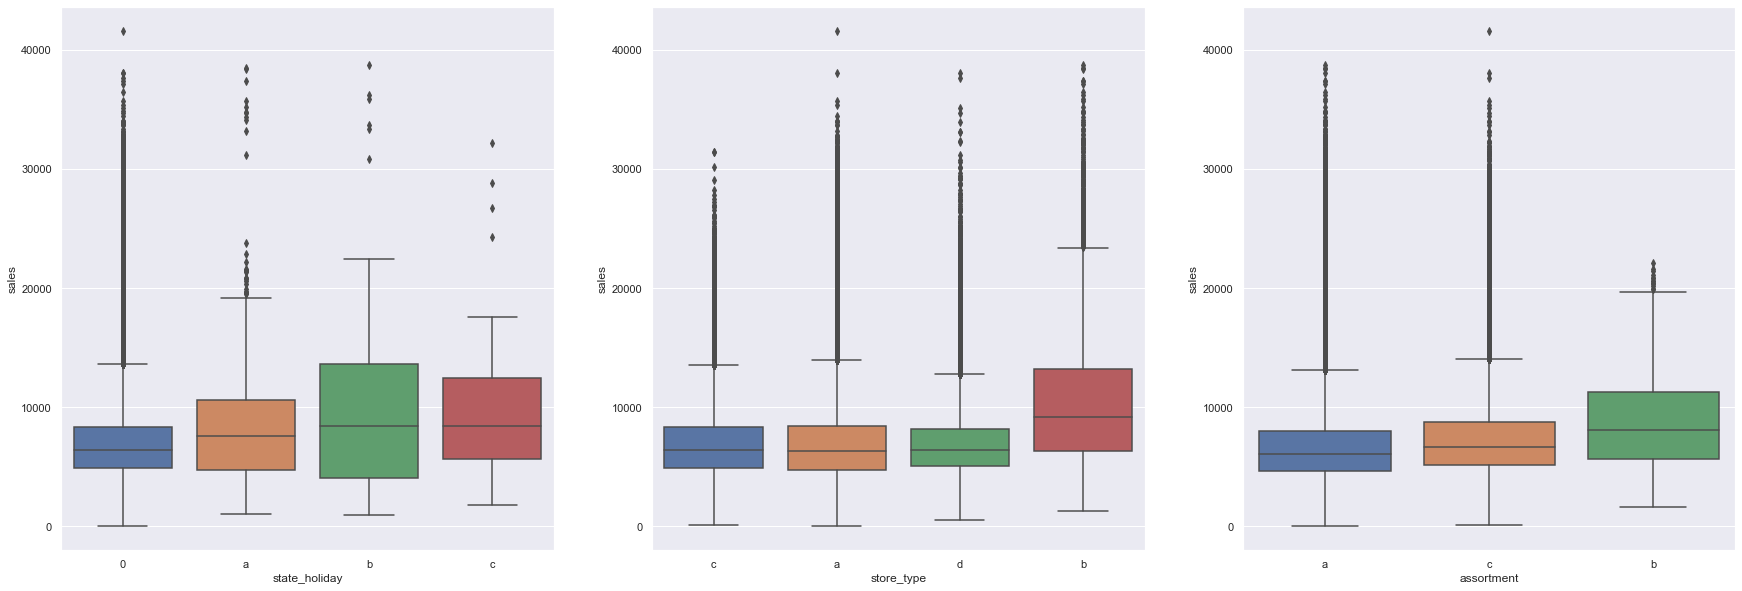

In [18]:
aux1 = df1[(df1['state_holiday'] != 0)  & (df1['sales'] > 0)]

plt.subplot(1, 3, 1)
sns.boxplot(x= 'state_holiday', y='sales', data=aux1)

plt.subplot(1, 3, 2)
sns.boxplot(x='store_type', y='sales', data=aux1)

plt.subplot(1, 3, 3)
sns.boxplot(x='assortment', y='sales', data=aux1)

# 2.0 Feature Enginnering

In [19]:
df2 = df1.copy()

In [20]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week

# year week
df2['year_week'] = df2['date'].dt.strftime('%W-%Y')

# competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year  = x['competition_open_since_year'],
                                                                 month = x['competition_open_since_month'],
                                                                 day=1), axis=1)

# competition_time_month
df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] ) /30 ).apply(lambda x: x.days).astype( int )
df2['competition_time_month'] = df2['competition_time_month'].apply(lambda x: 0 if x < 0 else x)

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + "-" + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', "%Y-%W-%w") - datetime.timedelta(days=7))

# promo_time_week
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

# assortment
# Assortment - describes an assortment level: a = basic, b = extra, c = extended
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else
                                                      'extra' if x =='b' else
                                                      'extended')

# state holiday
# StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, 
# are closed on state holidays. Note that all schools are closed on public holidays and 
# weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else
                                                            'easter_holiday' if x == 'b' else
                                                            'christmas' if x == 'c' else 'regular_day')

df2.sample(5).T

,785904,446811,402927,467972,334231
store,863,490,442,513,367
store_type,a,a,c,a,d
assortment,extended,basic,basic,basic,extended
competition_distance,21370.0,660.0,500.0,400.0,2640.0
competition_open_since_month,11,4,7,8,9
competition_open_since_year,2010,2013,2013,2013,2012
promo2,0,1,1,0,0
promo2_since_week,1,40,45,27,38
promo2_since_year,2014,2014,2009,2013,2013
promo_interval,0,"Jan,Apr,Jul,Oct","Feb,May,Aug,Nov",0,0


In [21]:
df2['week_of_year'] = df2['week_of_year'].astype(np.int64)
df2['competition_time_month'] = df2['competition_time_month'].astype(np.int64)
df2['promo_since'] = df2['promo_since'].astype(np.int64)
df2['promo_time_week'] = df2['promo_time_week'].astype(np.int64)

# 3.0 Columns Selection

In [22]:
df3 = df2.copy()

## 3.1 Rows select

In [23]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2 Columns Drop

In [24]:
df3.columns

Index(['store', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'promo_interval',
       'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'month_map', 'is_promo', 'year',
       'month', 'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

In [25]:
columns_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3.drop(columns_drop, axis=1)
df3.columns

Index(['store', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'promo_interval',
       'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'month_map', 'is_promo', 'year',
       'month', 'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4.0 Exploratory Data Analysis

In [26]:
df4 = df3.copy()

## 4.1 Univariate Analysis

### 4.1.1 Response Variable

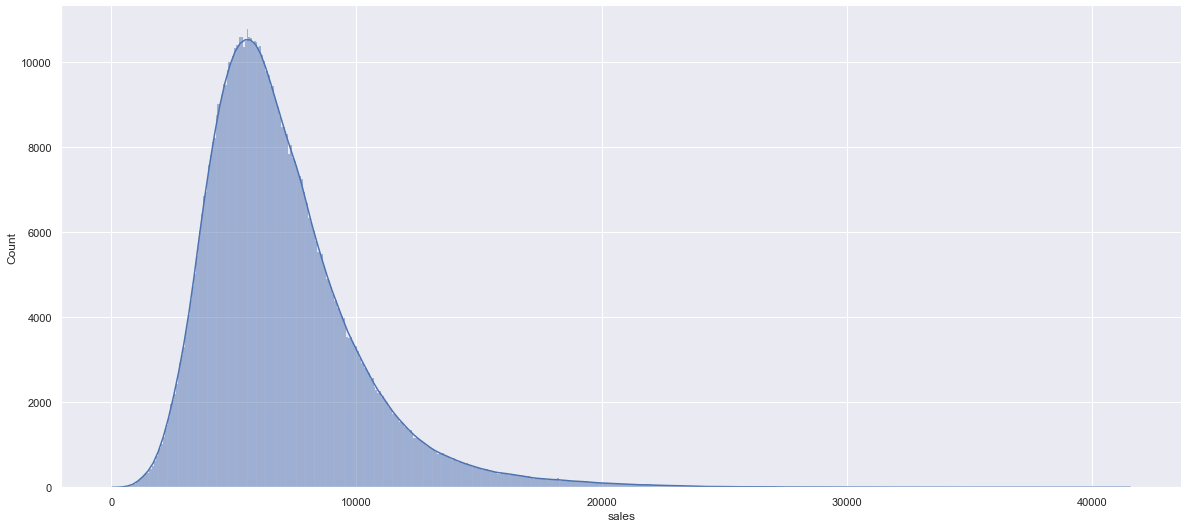

In [27]:
sns.displot(df4['sales'], kde=True).figure.set_size_inches(20, 8)

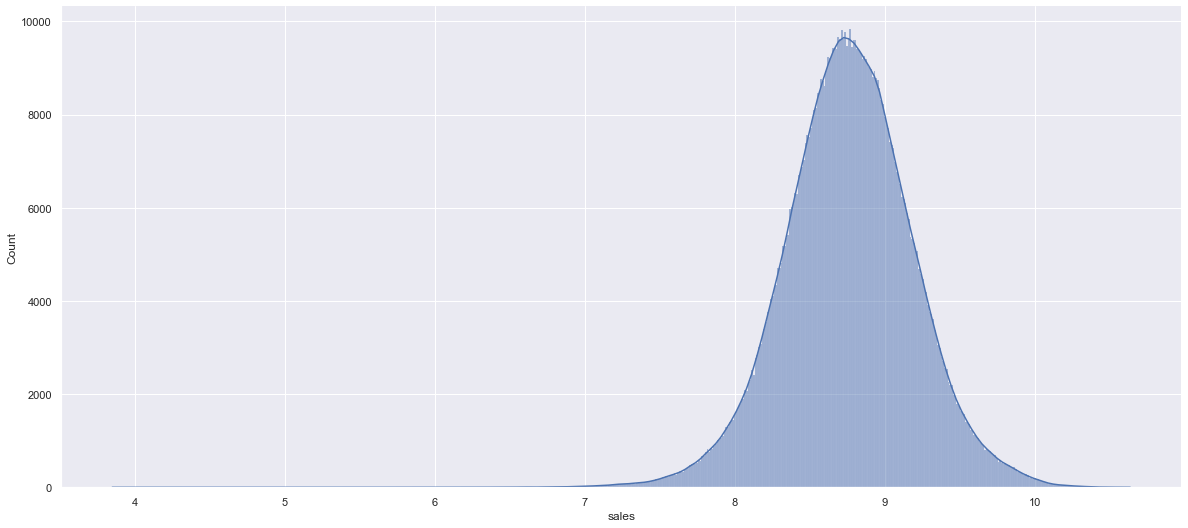

In [28]:
sns.displot(np.log1p(df4['sales']), kde=True).figure.set_size_inches(20, 8)

### 4.1.2 Numerical Variable

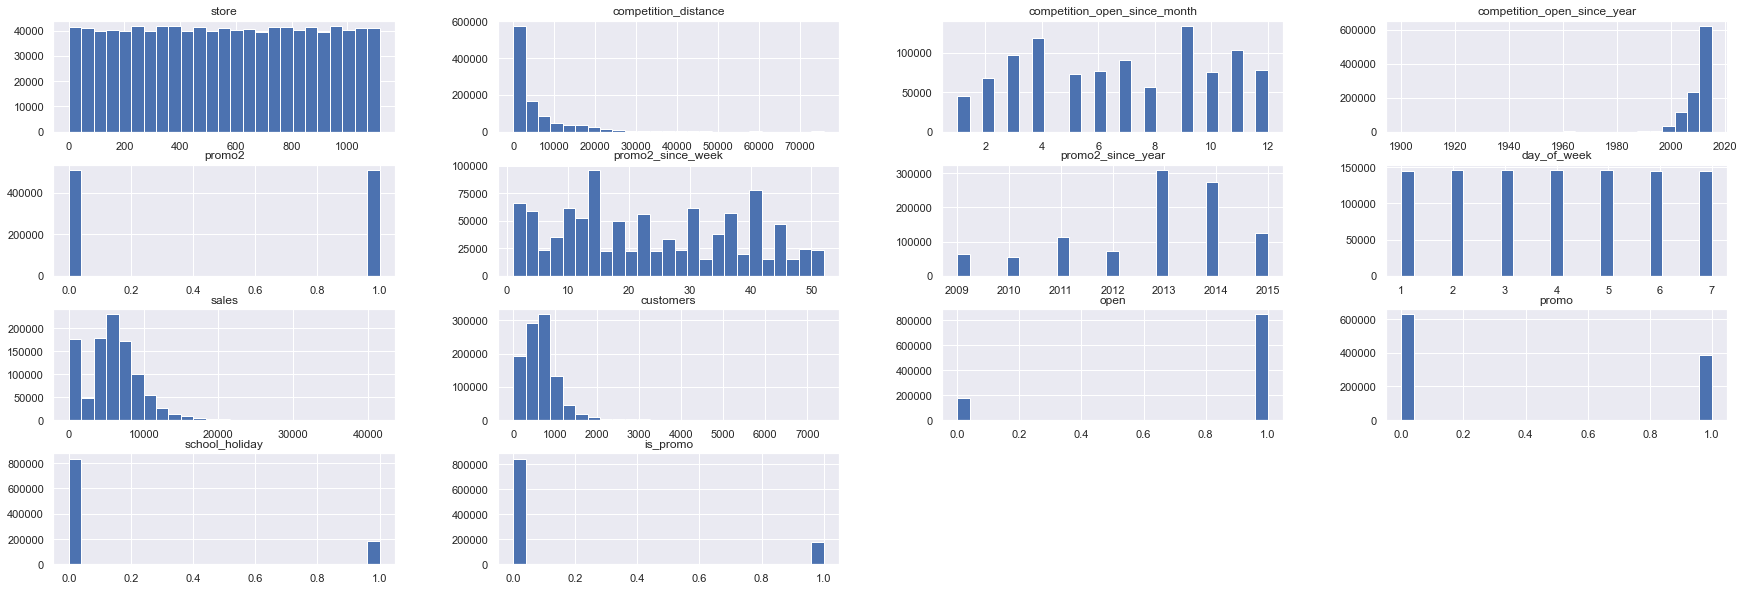

In [29]:
df_num_attributes.hist( bins= 25 );

### 4.1.3 Categorical Variable

<AxesSubplot:xlabel='sales', ylabel='Density'>

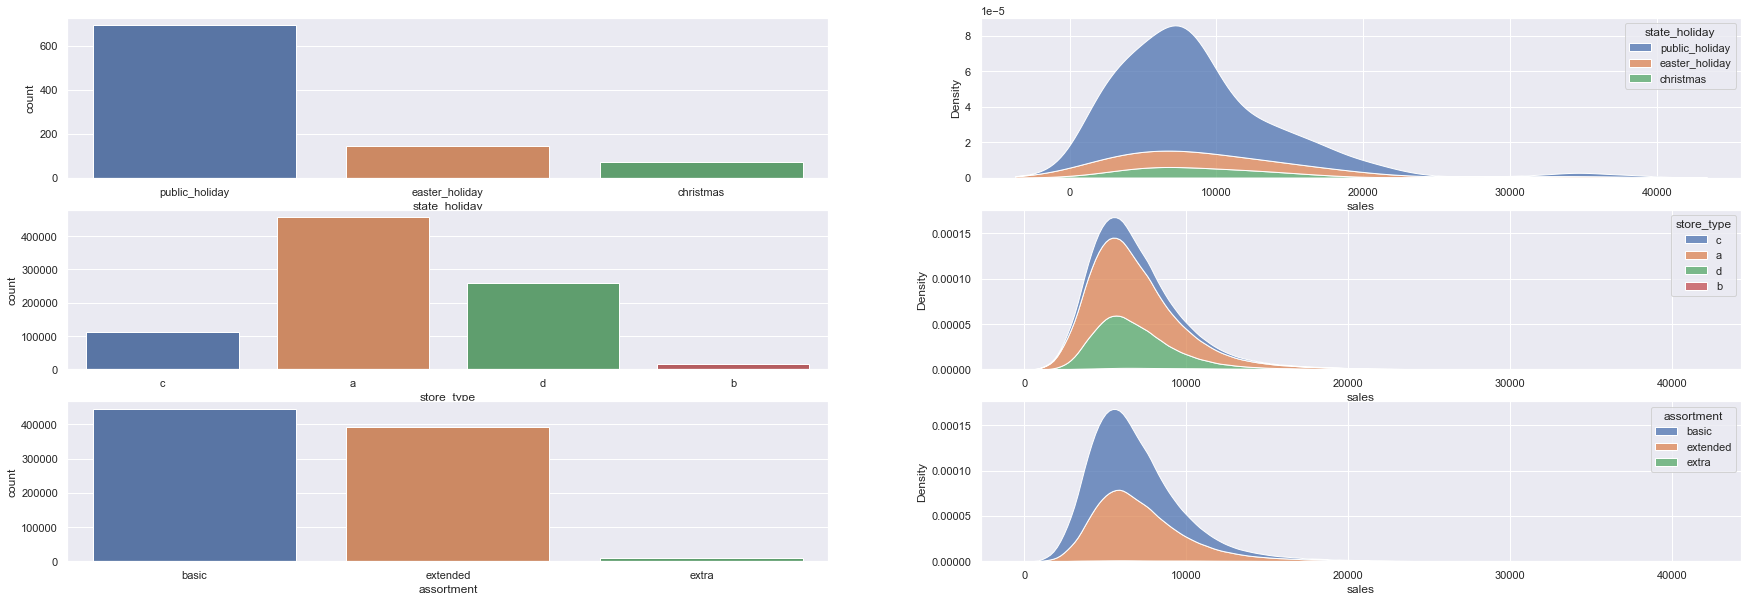

In [30]:
# State Holiday
aux1 = df4[df4['state_holiday'] != 'regular_day']
plt.subplot(3, 2, 1)
sns.countplot(x='state_holiday', data=aux1)

plt.subplot(3, 2, 2)
sns.kdeplot(data=aux1[['state_holiday', 'sales']], x="sales", hue="state_holiday", multiple="stack")

# Store_type
plt.subplot(3, 2, 3)
sns.countplot(x='store_type', data=df4)

plt.subplot(3, 2, 4)
sns.kdeplot(data=df4[['store_type', 'sales']], x="sales", hue="store_type", multiple="stack")

# Assortment
plt.subplot(3, 2, 5)
sns.countplot(x='assortment', data=df4)

plt.subplot(3, 2, 6)
sns.kdeplot(data=df4[['assortment', 'sales']], x="sales", hue="assortment", multiple="stack")


## 4.2 Bivariate Analysis

### 4.2.1 Questions

1. Lojas com maior sortimentos deveriam vender mais.
2. Lojas com competidores mais próximos deveriam vender menos.
3. Lojas com competidores à mais tempo deveriam vendem mais.
4. Lojas com promoções ativas por mais tempo deveriam vender mais.
5. Lojas com mais dias de promoção deveriam vender mais.
7. Lojas com mais promoções consecutivas deveriam vender mais.
8. Lojas abertas durante o feriado de Natal deveriam vender mais.
9. Lojas deveriam vender mais ao longo dos anos.
10. Lojas deveriam vender mais no segundo semestre do ano.
11. Lojas deveriam vender mais depois do dia 10 de cada mês.
12. Lojas deveriam vender menos aos finais de semana.
13. Lojas deveriam vender menos durante os feriados escolares.

### 4.2.2 Answers

#### H1 - Lojas com maior sortimentos deveriam vender mais.
**<font color='blue'>R: Verdadeiro, lojas com maior sortimento vende mais.</font>**

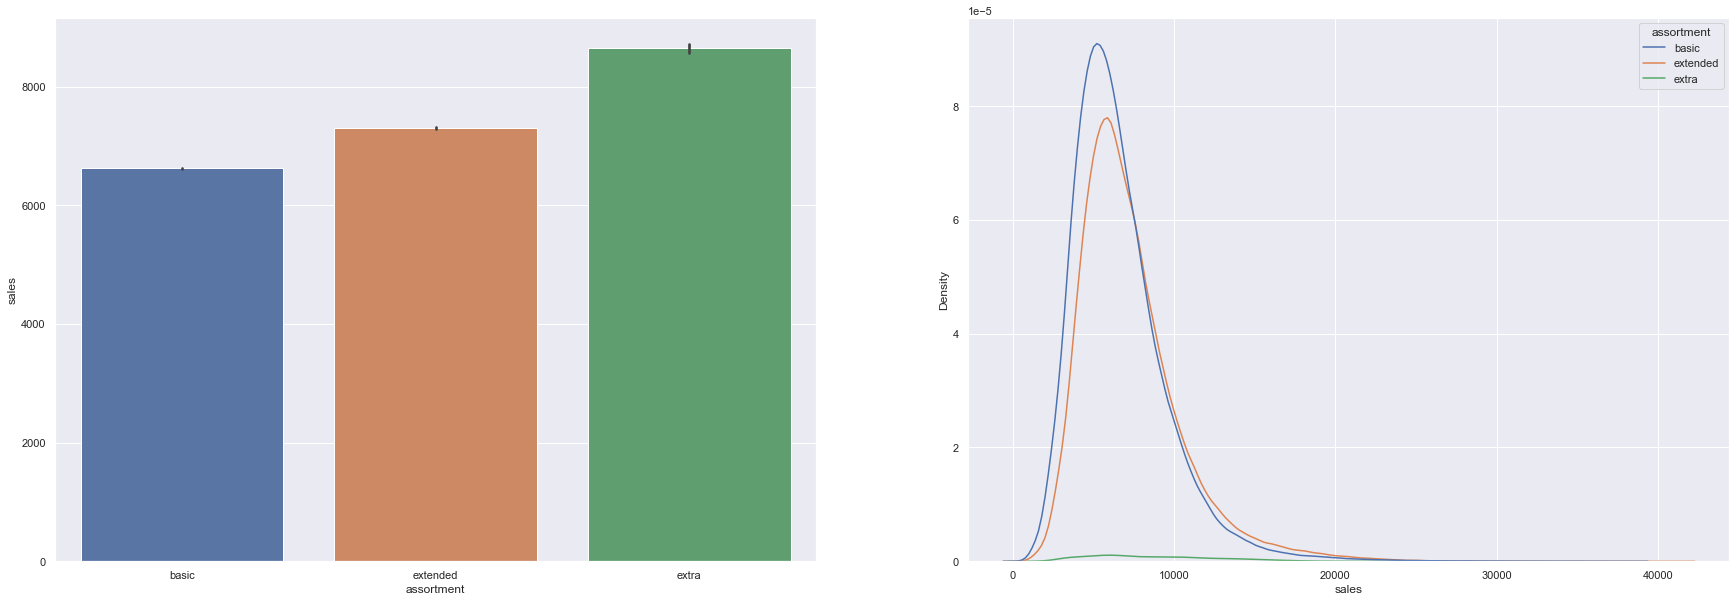

In [31]:
plt.subplot(1, 2, 1)
sns.barplot(data=df4[['sales', 'assortment']], x='assortment', y='sales');

plt.subplot(1, 2, 2)
sns.kdeplot(data=df4[['sales', 'assortment']], x='sales', hue='assortment');

#### H2 - Lojas com competidores mais próximos deveriam vender menos.
**<font color='Red'>R: Falso, lojas com competidores mais próximos vendem mais.</font>**

D:\Users\gtvmi\anaconda3\lib\site-packages\seaborn\distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
D:\Users\gtvmi\anaconda3\lib\site-packages\seaborn\distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


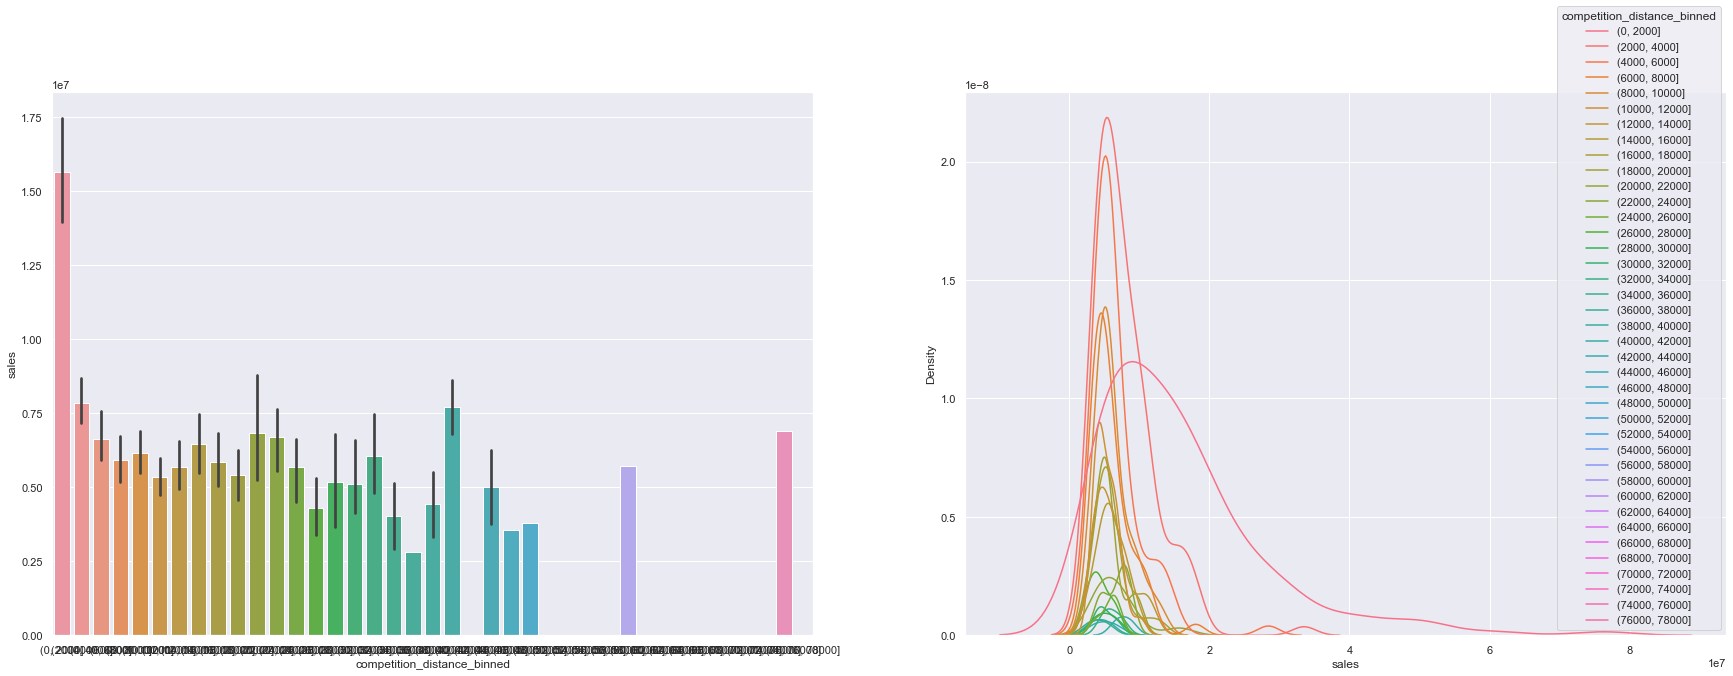

In [32]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

bins = list(np.arange(0, 80000, 2000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)

plt.subplot(1, 2, 1)
sns.barplot(data=aux1, x='competition_distance_binned', y='sales');

plt.subplot(1, 2, 2)
sns.kdeplot(data=aux1, x='sales', hue='competition_distance_binned' );


#### H3 - Lojas com competidores à mais tempo deveriam vendem mais.
**<font color='blue'>R: Verdadeiro, lojas com competidores a mais tempo, vendem mais.</font>**

C:\Users\gtvmi\AppData\Local\Temp\ipykernel_3748\4021773449.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aux1['competition_time_month_binned'] = pd.cut(aux1['competition_time_month'], bins=bins)


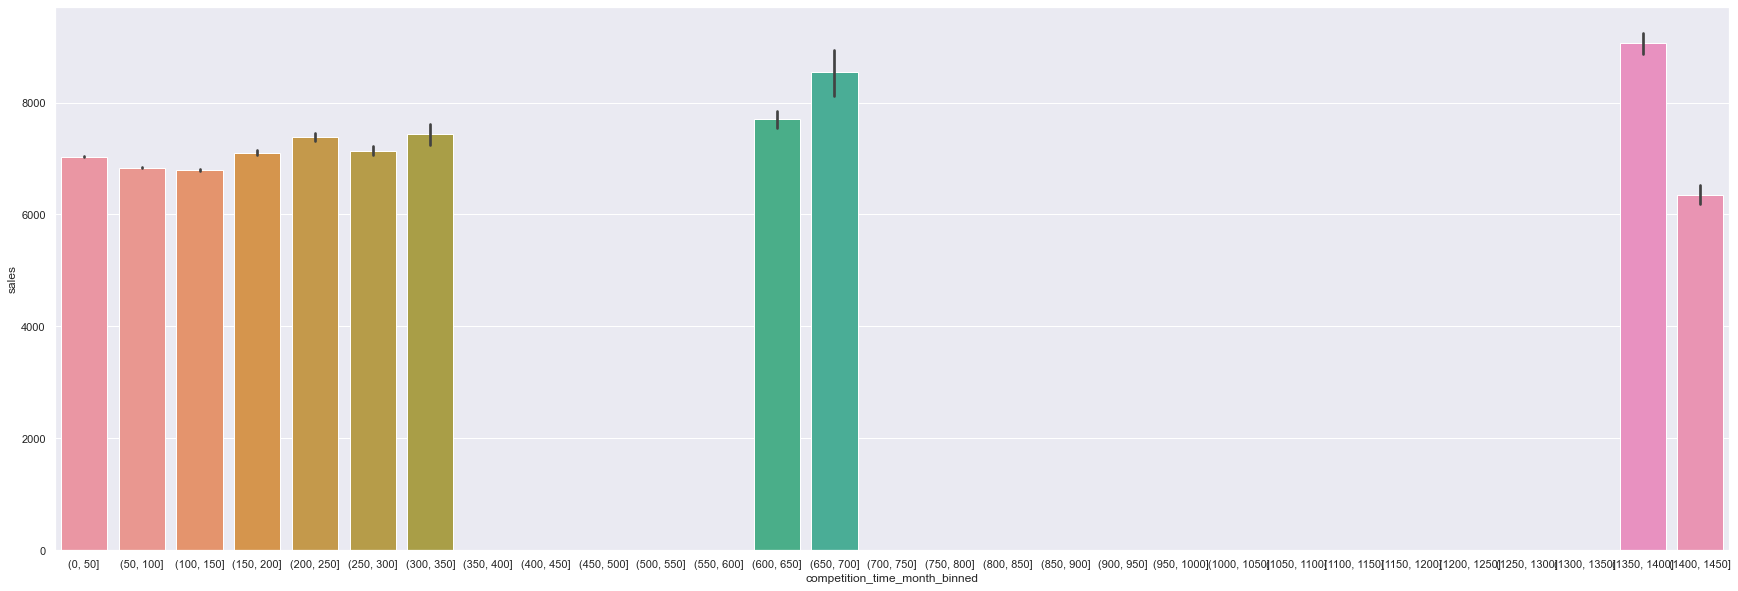

In [33]:
aux1 = df4[['competition_time_month', 'sales']]
bins = list(np.arange(0, 1500, 50))
aux1['competition_time_month_binned'] = pd.cut(aux1['competition_time_month'], bins=bins)

sns.barplot(data=aux1, x='competition_time_month_binned', y='sales');

#### H4 - Lojas com promoções ativas por mais tempo deveriam vender mais.
**<font color='blue'>R: Verdadeiro, lojas com promoções ativas a mais tempo, vendem mais.</font>**

C:\Users\gtvmi\AppData\Local\Temp\ipykernel_3748\242037571.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aux1['promo_time_week_binned'] = pd.cut(aux1['promo_time_week'], bins=bins)


<AxesSubplot:xlabel='promo_time_week_binned', ylabel='sales'>

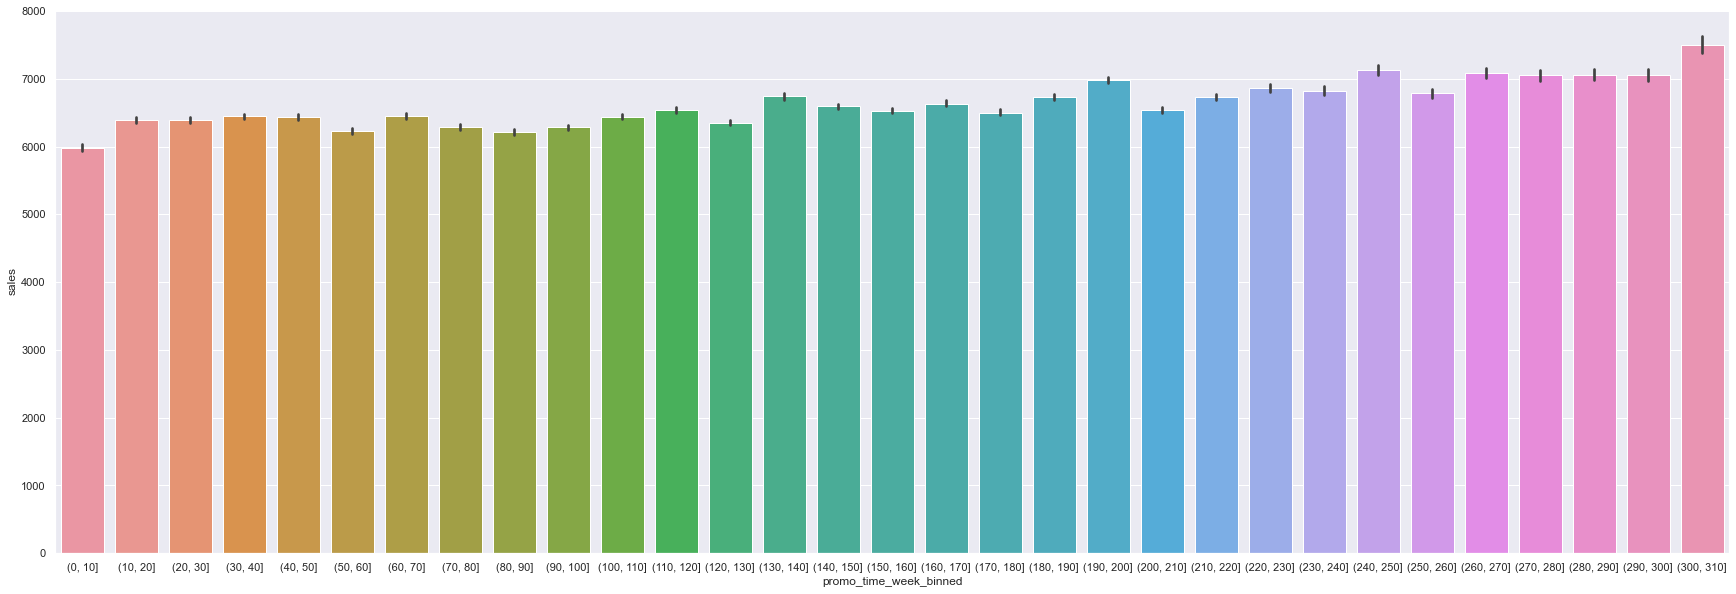

In [34]:
aux1 = df4[['promo_time_week', 'sales']]
bins = list(np.arange(0, 320, 10))
aux1['promo_time_week_binned'] = pd.cut(aux1['promo_time_week'], bins=bins)

sns.barplot(data=aux1, x='promo_time_week_binned', y='sales')

#### <s>H5. Lojas com mais dias de promoção deveriam vender mais.</s>
**<font color='blue'>R:</font>**

#### H6 - Lojas com mais promoções consecutivas deveriam vender mais.
**<font color='red'>R: Falso. Lojas com promoções consecutivas vendem menos. Lojas com promoções mais curtas vendem mais.</font>**

In [35]:
aux1 = df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index()
aux1

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


<AxesSubplot:xlabel='promo2', ylabel='sales'>

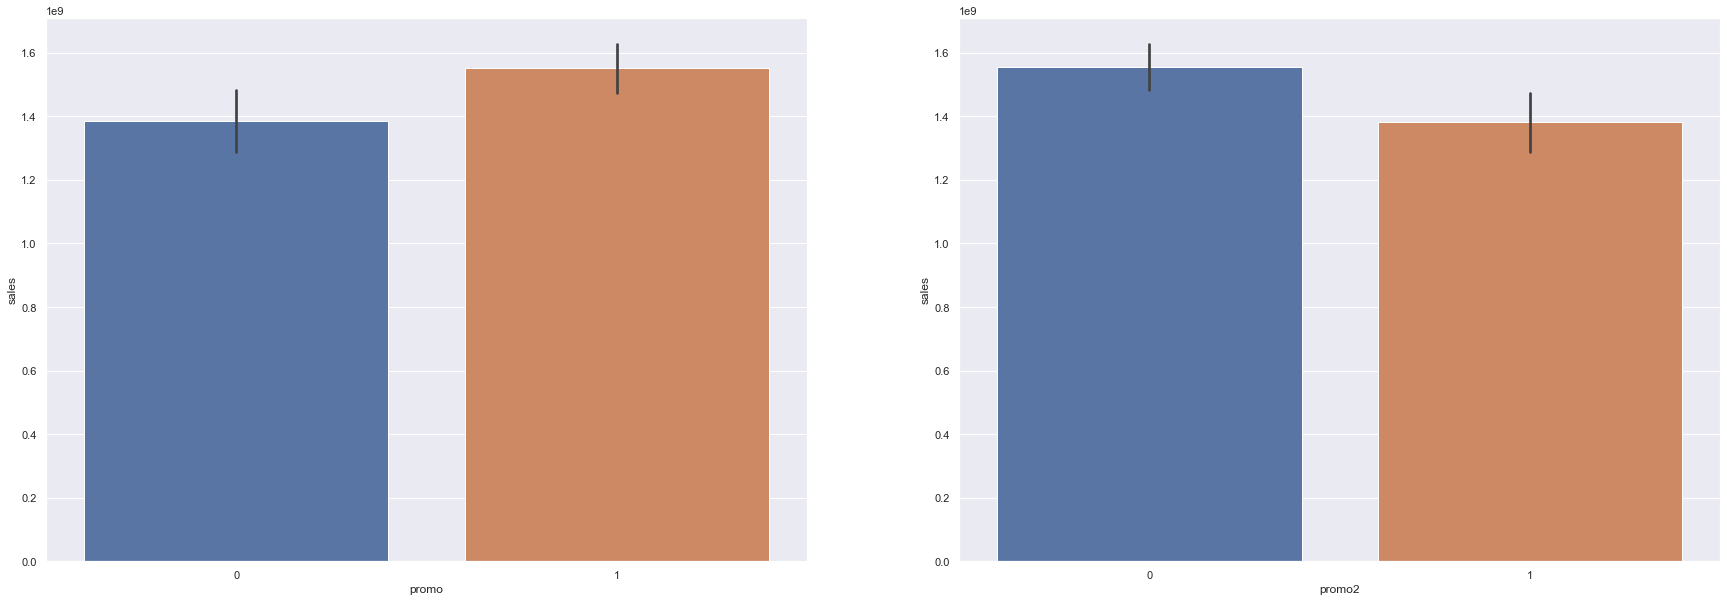

In [36]:
plt.subplot(1, 2, 1)
sns.barplot(data=aux1, x='promo', y='sales');

plt.subplot(1, 2, 2)
sns.barplot(data=aux1, x='promo2', y='sales')

# sns.barplot(data=, x='promo', y='sales')

#### H7 - Lojas abertas durante o feriado de Natal deveriam vender mais.
**<font color='red'>R: Falso. Lojas abertas durante a páscoa vendem mais.</font>**

<AxesSubplot:xlabel='state_holiday', ylabel='sales'>

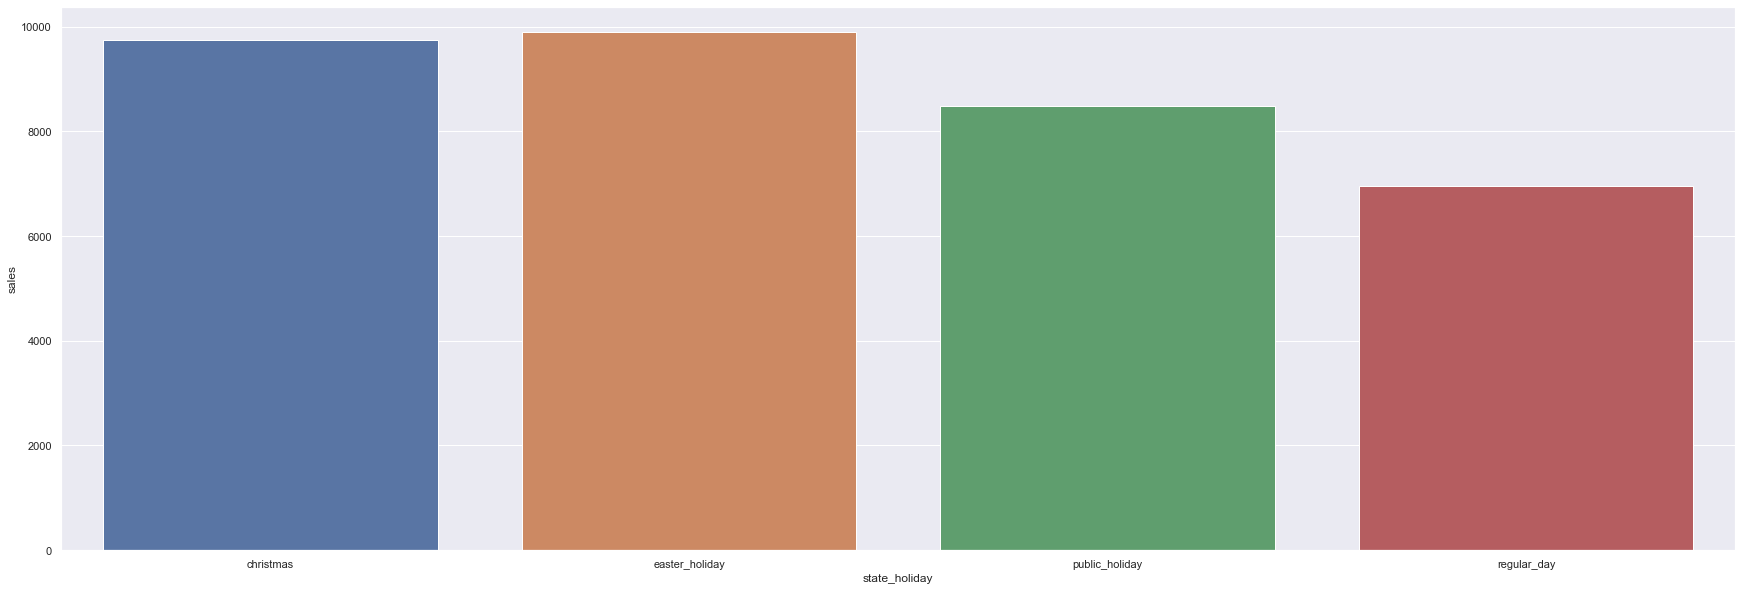

In [37]:
aux1 = df4[['state_holiday', 'sales']].groupby('state_holiday').mean().reset_index()

sns.barplot(data=aux1, x='state_holiday', y='sales')

#### H8 - Lojas deveriam vender mais ao longo dos anos.
**<font color='blue'>R: Verdadeiro. As lojas vem vendendo mais ao longo dos anos.</font>**

<AxesSubplot:xlabel='year', ylabel='sales'>

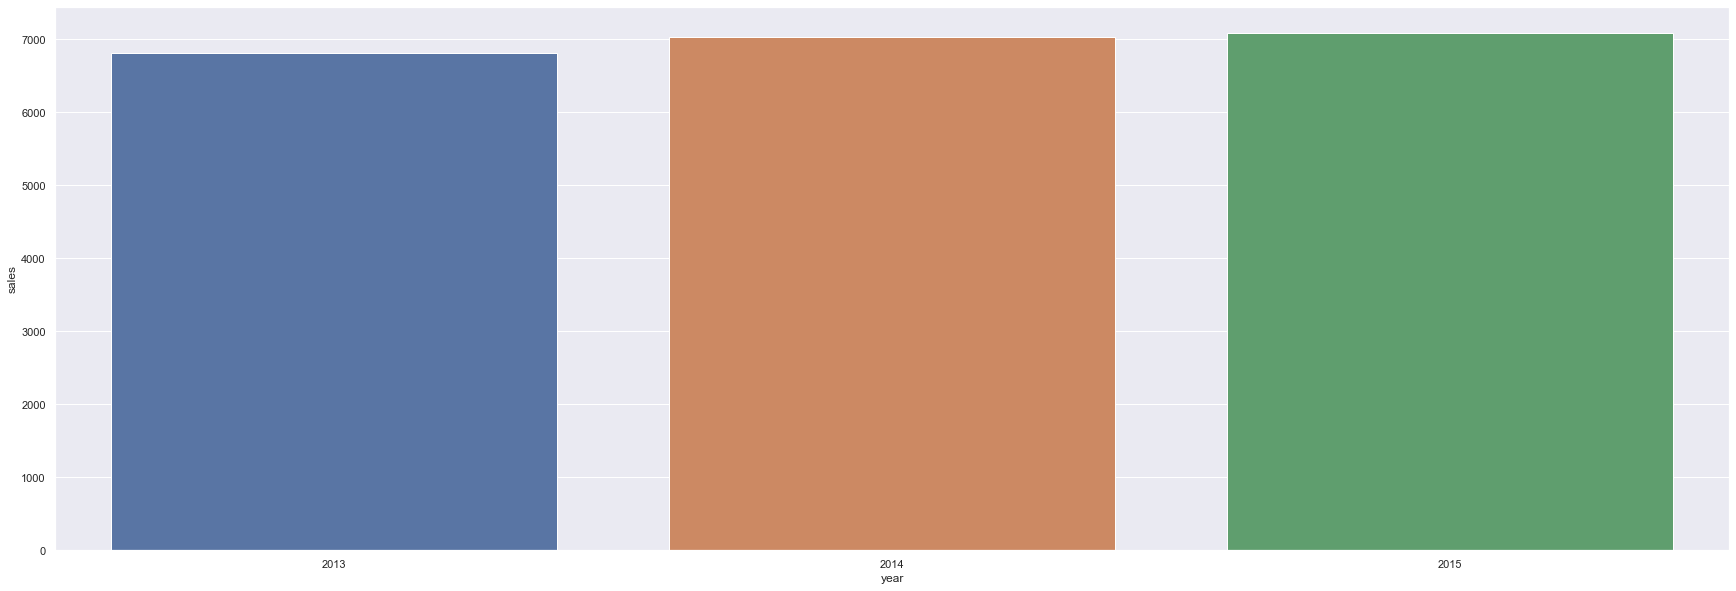

In [38]:
aux1 = df4[['sales', 'year']].groupby('year').mean().reset_index()

sns.barplot(data=aux1, x='year', y='sales')

#### H9 - Lojas deveriam vender mais no segundo semestre do ano.
**<font color='blue'>R: Verdadeiro para os anos de 2013 e 2015 (não fechado). </font><font color='red'>R: Falso para os ano de 2014.</font>**

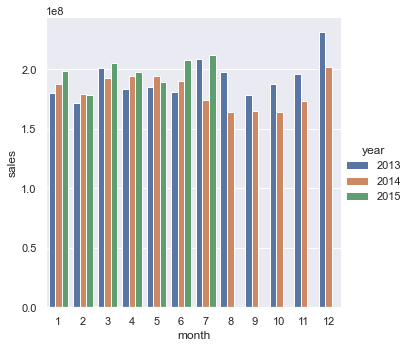

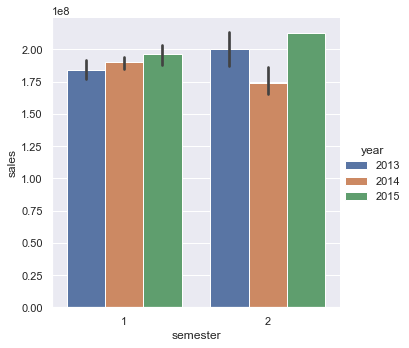

In [39]:
aux1 = df4[['month', 'year', 'sales']].groupby(['year', 'month']).sum('sales').reset_index()
aux1['semester'] = aux1['month'].apply(lambda x: 1 if x <= 6 else 2)

# plt.subplot(1, 2, 1)
sns.catplot(data=aux1, x='month', y='sales', hue='year', kind='bar')

# plt.subplot(1, 2, 2)
sns.catplot(data=aux1, x='semester', y='sales', hue='year', kind='bar')


#### H10 - Lojas deveriam vender mais depois do dia 10 de cada mês.
**<font color='blue'>R: Verdadeiro. As lojas vendem mais depois do dia 10 de cada mês, na média. </font>**

<AxesSubplot:xlabel='period', ylabel='sales'>

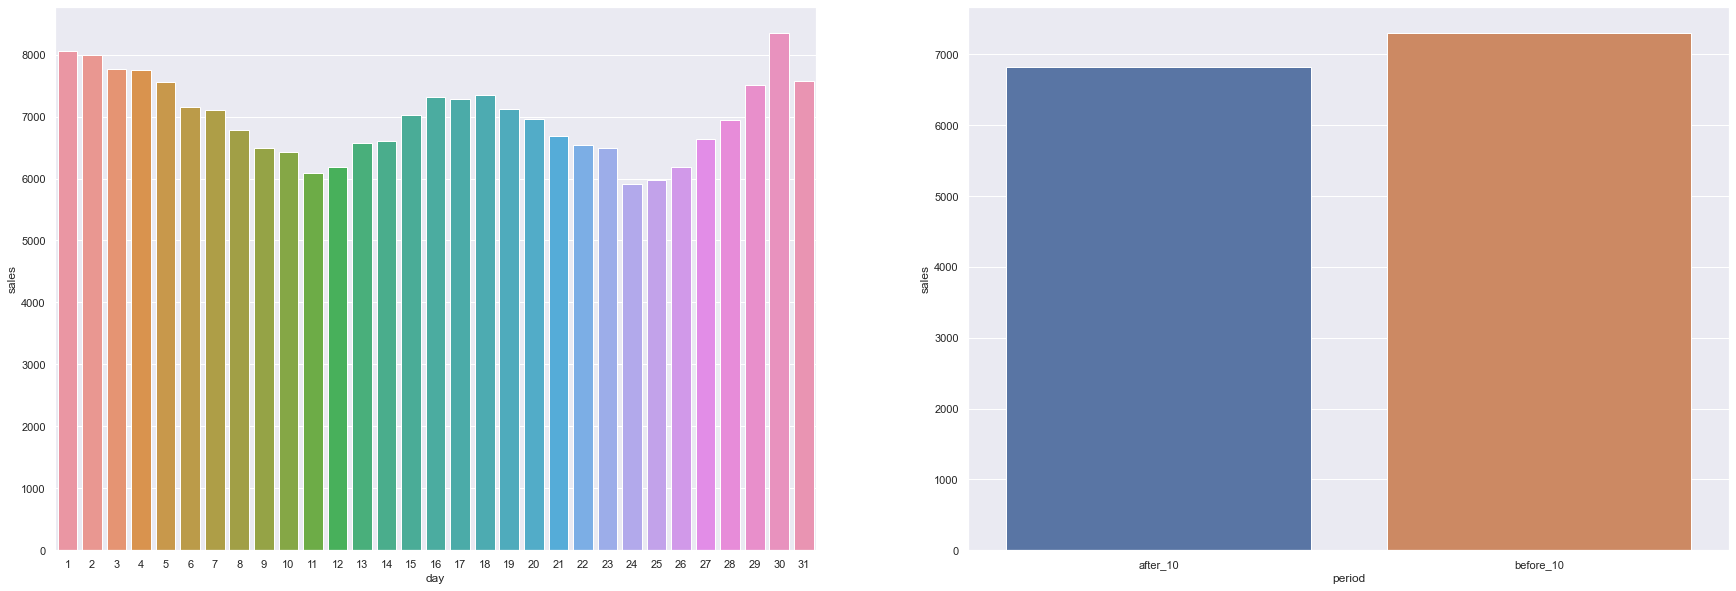

In [40]:
aux1 = df4[['day', 'sales']].groupby(['day']).mean('sales').reset_index()

plt.subplot(1, 2, 1)
sns.barplot(data=aux1, x='day', y='sales')


aux1['period'] = aux1['day'].apply(lambda x: 'before_10' if x <= 10 else 'after_10')
aux1 = aux1[['period', 'sales']].groupby('period').mean('sales').reset_index()
plt.subplot(1, 2, 2)
sns.barplot(data=aux1, x='period', y='sales')


#### H11 - Lojas deveriam vender menos aos finais de semana.
**<font color='blue'>R: Verdadeiro. Em média, as lojas vendem menos no final de semana. </font>**

<AxesSubplot:xlabel='weekend', ylabel='sales'>

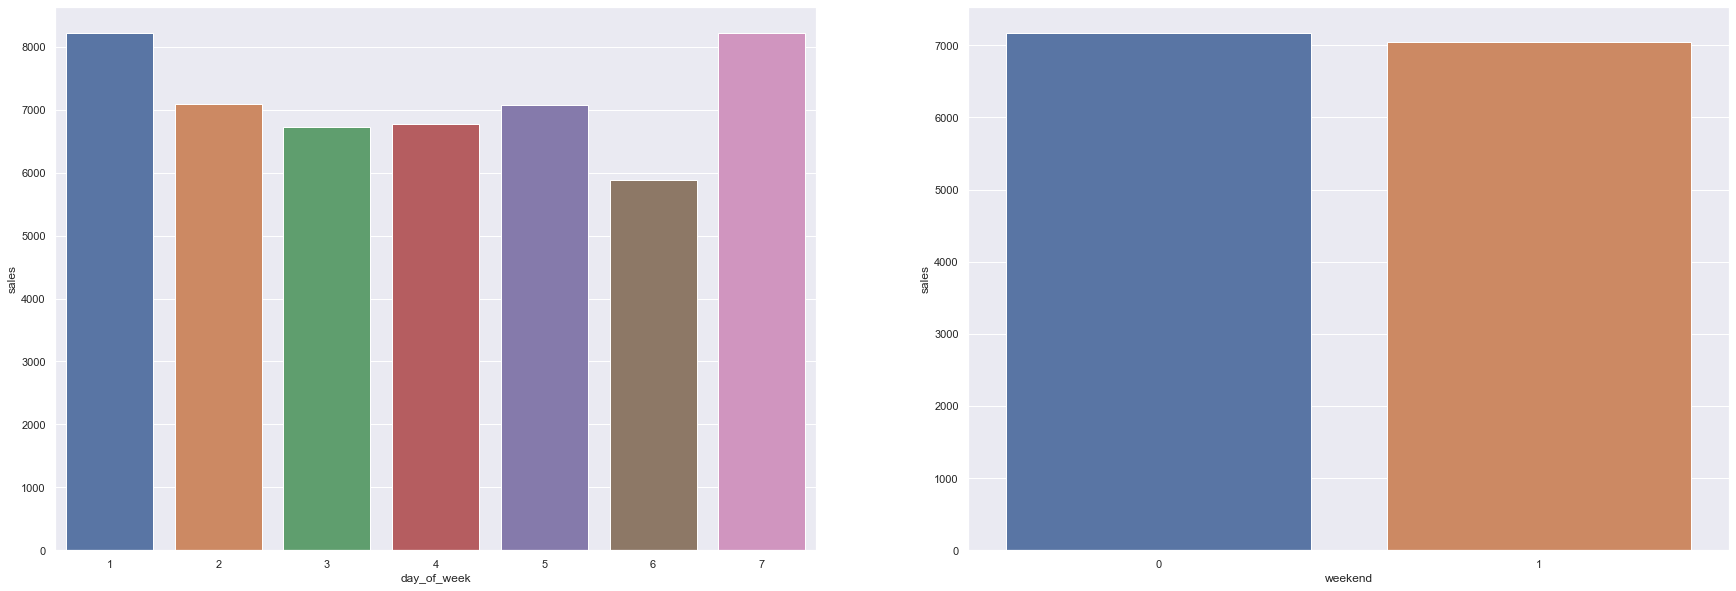

In [41]:
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').mean('sales').reset_index()

plt.subplot(1, 2, 1)
sns.barplot(data=aux1, x='day_of_week', y='sales')

aux1['weekend'] = aux1['day_of_week'].apply(lambda x: 1 if x >= 6 else 0)
aux1 = aux1[['weekend', 'sales']].groupby('weekend').mean('sales').reset_index()

plt.subplot(1, 2, 2)
sns.barplot(data=aux1, x='weekend', y='sales')

#### H12 - Lojas deveriam vender menos durante os feriados escolares.
**<font color='red'>R: Falso. Há mais vendas em feriados escolares. </font>**

<AxesSubplot:xlabel='school_holiday', ylabel='sales'>

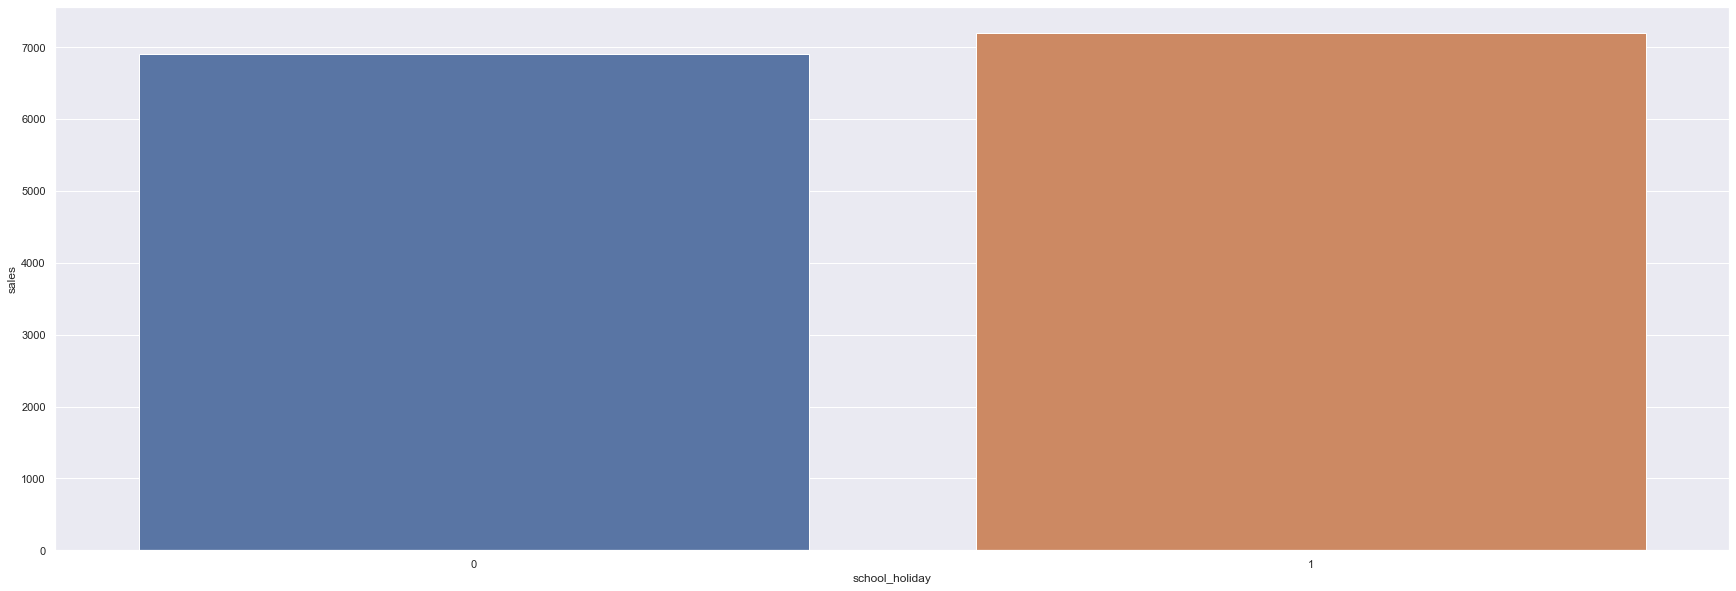

In [42]:
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').mean('sales').reset_index()

sns.barplot(data=aux1, x='school_holiday', y='sales')

## 4.2 Multivariate Analysis

### 4.2.1 Numerical Attributes

<AxesSubplot:>

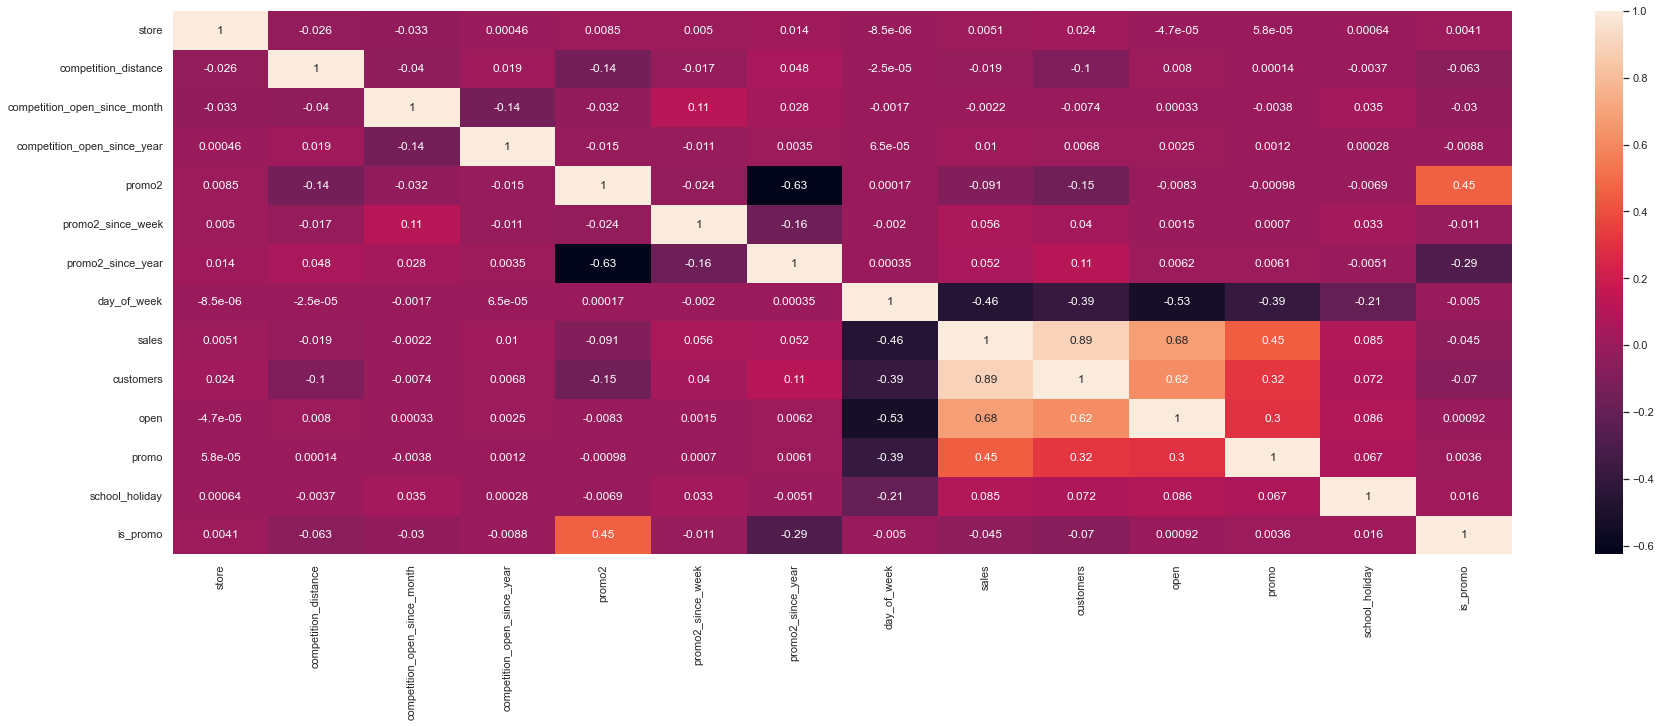

In [43]:
sns.heatmap(df_num_attributes.corr(method='pearson'), annot=True)

### 4.2.2 Categorical Attributes

In [44]:
aux1 = df_cat_attributes[df_cat_attributes['state_holiday'] != 0]

# State_holiday
a1 = cramer_v(aux1['state_holiday'], aux1['state_holiday'])
a2 = cramer_v(aux1['state_holiday'], aux1['assortment'])
a3 = cramer_v(aux1['state_holiday'], aux1['store_type'])

# Assortment
a4 = cramer_v(aux1['assortment'], aux1['state_holiday'])
a5 = cramer_v(aux1['assortment'], aux1['assortment'])
a6 = cramer_v(aux1['assortment'], aux1['store_type'])

# Store_type
a7 = cramer_v(aux1['store_type'], aux1['state_holiday'])
a8 = cramer_v(aux1['store_type'], aux1['assortment'])
a9 = cramer_v(aux1['store_type'], aux1['store_type'])

# Relationship DataFrame
aux1 = pd.DataFrame({'state_holiday' : [a1, a2, a3],
              'assortment' : [a4, a5, a6],
              'store_type' : [a7, a8, a9]})

aux1 = aux1.set_index(aux1.columns)

<AxesSubplot:>

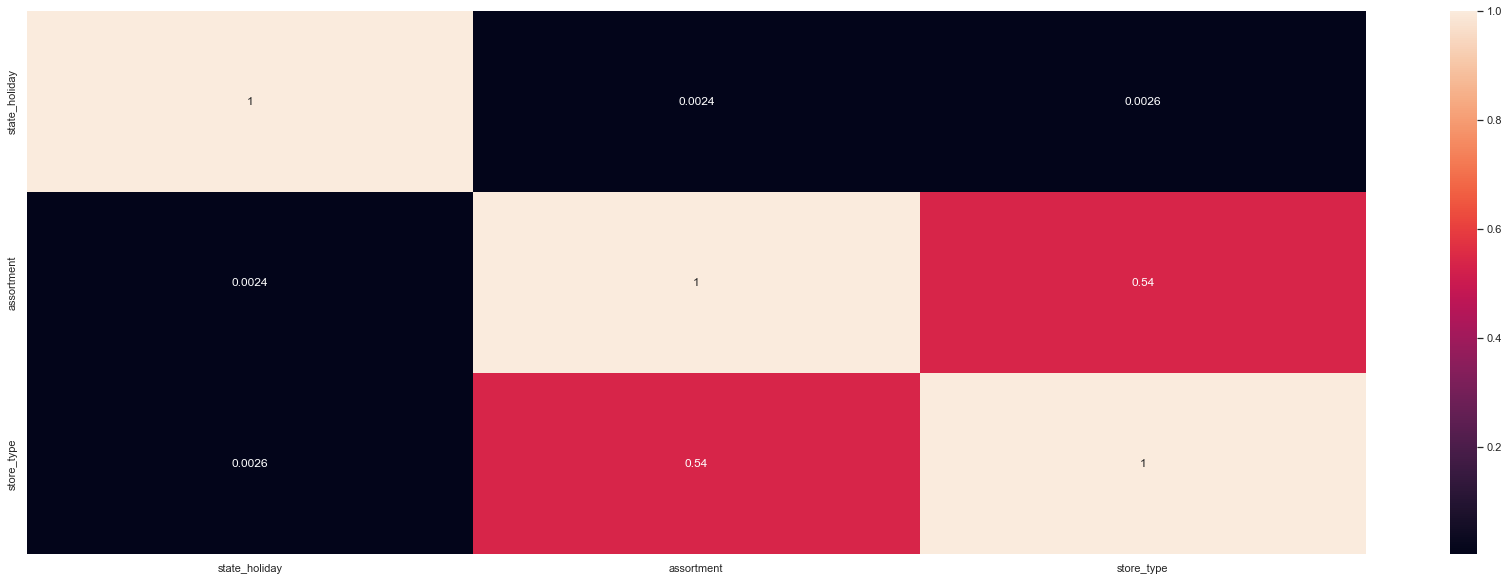

In [45]:
sns.heatmap(aux1, annot=True)

# 5.0 Data Preparation

In [46]:
df5 = df4.copy()

## 5.1 Rescaling

In [47]:
rs = RobustScaler()

# Competition_Distance
df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values )

# Competition_time_month
df5['competition_time_month'] = rs.fit_transform( df5[['competition_time_month']].values )

mms = MinMaxScaler()

# Promo_time_week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)

# year
df5['year'] = mms.fit_transform(df5[['year']].values)

## 5.2 Transformation

### 5.2.1 Encoding

In [48]:
# State Holiday - One hot Encoding
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

# Store Type - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])

# Assortment - Ordinal Encoding
assortment_dict = {'basic':1, 'extra':2, 'extended':3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

df5

,store,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,...,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day
0,1,2,1,-0.169903,9,2008,0,31,2015,0,...,31,30-2015,2008-09-01,0.918919,1437955200000000000,0.287016,0,0,0,1
1,1,2,1,-0.169903,9,2008,0,31,2015,0,...,31,30-2015,2008-09-01,0.918919,1437955200000000000,0.287016,0,0,0,1
2,1,2,1,-0.169903,9,2008,0,31,2015,0,...,31,30-2015,2008-09-01,0.918919,1437955200000000000,0.287016,0,0,0,1
3,1,2,1,-0.169903,9,2008,0,31,2015,0,...,31,30-2015,2008-09-01,0.918919,1437955200000000000,0.287016,0,0,0,1
4,1,2,1,-0.169903,9,2008,0,31,2015,0,...,31,30-2015,2008-09-01,0.918919,1437955200000000000,0.287016,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017202,1115,3,3,0.490291,1,2013,1,22,2012,"Mar,Jun,Sept,Dec",...,2,01-2013,2013-01-01,-0.216216,1337558400000000000,0.362187,0,0,0,1
1017204,1115,3,3,0.490291,1,2013,1,22,2012,"Mar,Jun,Sept,Dec",...,1,00-2013,2013-01-01,-0.216216,1337558400000000000,0.359909,0,0,0,1
1017205,1115,3,3,0.490291,1,2013,1,22,2012,"Mar,Jun,Sept,Dec",...,1,00-2013,2013-01-01,-0.216216,1337558400000000000,0.359909,0,0,0,1
1017206,1115,3,3,0.490291,1,2013,1,22,2012,"Mar,Jun,Sept,Dec",...,1,00-2013,2013-01-01,-0.216216,1337558400000000000,0.359909,0,0,0,1


### 5.2.2 Response Variable Transformation

In [49]:
df5['sales'] = np.log1p(df5['sales'])

### 5.2.3 Nature Transformation

In [50]:
# Day of Week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )

# month - Transformação Ciclica
df5['month_sin'] = df5['month'].apply( lambda x: np.sin ( x * ( 2.*np.pi/12 ) ) )
df5['month_cos'] = df5['month'].apply( lambda x: np.cos ( x * ( 2.*np.pi/12 ) ) )
   
# day

df5['day_sin'] = df5['day'].apply( lambda x: np.sin ( x * ( 2.*np.pi/30 ) ) )
df5['day_cos'] = df5['day'].apply( lambda x: np.cos ( x * ( 2.*np.pi/30 ) ) )

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos( x * ( 2. * np.pi/52 ) ) )

df5


,store,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,...,state_holiday_public_holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
0,1,2,1,-0.169903,9,2008,0,31,2015,0,...,0,1,-0.974928,-0.222521,-0.5,-0.866025,2.079117e-01,0.978148,-0.568065,-0.822984
1,1,2,1,-0.169903,9,2008,0,31,2015,0,...,0,1,-0.433884,-0.900969,-0.5,-0.866025,-2.449294e-16,1.000000,-0.568065,-0.822984
2,1,2,1,-0.169903,9,2008,0,31,2015,0,...,0,1,0.433884,-0.900969,-0.5,-0.866025,-2.079117e-01,0.978148,-0.568065,-0.822984
3,1,2,1,-0.169903,9,2008,0,31,2015,0,...,0,1,0.974928,-0.222521,-0.5,-0.866025,-4.067366e-01,0.913545,-0.568065,-0.822984
4,1,2,1,-0.169903,9,2008,0,31,2015,0,...,0,1,0.781831,0.623490,-0.5,-0.866025,-5.877853e-01,0.809017,-0.568065,-0.822984
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017202,1115,3,3,0.490291,1,2013,1,22,2012,"Mar,Jun,Sept,Dec",...,0,1,0.781831,0.623490,0.5,0.866025,9.945219e-01,0.104528,0.239316,0.970942
1017204,1115,3,3,0.490291,1,2013,1,22,2012,"Mar,Jun,Sept,Dec",...,0,1,-0.781831,0.623490,0.5,0.866025,8.660254e-01,0.500000,0.120537,0.992709
1017205,1115,3,3,0.490291,1,2013,1,22,2012,"Mar,Jun,Sept,Dec",...,0,1,-0.974928,-0.222521,0.5,0.866025,7.431448e-01,0.669131,0.120537,0.992709
1017206,1115,3,3,0.490291,1,2013,1,22,2012,"Mar,Jun,Sept,Dec",...,0,1,-0.433884,-0.900969,0.5,0.866025,5.877853e-01,0.809017,0.120537,0.992709


# 6. Feature Selection - Boruta

In [51]:
df6 = df5.copy()

## 6.1 Split dataset into train and test

In [52]:
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week', 'promo_interval', 'month_map']

# cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']
df6 = df6.drop(cols_drop, axis=1)

In [53]:
df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days=6*7)

Timestamp('2015-06-19 00:00:00')

In [54]:
# Training Dataset
x_train = df6[df6['date'] < '2015-06-19']
y_train = x_train['sales']

# Test Dataset
x_test = df6[df6['date'] >= '2015-06-19']
y_test = x_test['sales']

## 6.2 Boruta as Feature Selection

In [94]:
# training and test dataset for Boruta

x_train_n = x_train.drop(columns=['date', 'sales'], axis= 1).values
y_train_n = y_train.values.ravel()

# Define Random Forest Regressor
rf = RandomForestRegressor(n_jobs=1)

# Define Boruta
boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42 ).fit(x_train_n, y_train_n)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	29
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	29
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	29
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	29
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	29
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	29
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	29
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	18
Tentative: 	0
Rejected: 	11


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	18
Tentative: 	0
Rejected: 	11


## 6.3 Best Features from Boruta 

In [58]:
cols_selected = boruta.support_.tolist()

# best features
x_train_fs = x_train.drop(columns=['date', 'sales'], axis=1)
cols_selected_boruta = x_train_fs.iloc[:, cols_selected].columns.tolist()

# Not Selected boruta
cols_not_selected_boruta = (list(np.setdiff1d(x_train_fs.columns, cols_selected_boruta)))

NameError: name 'boruta' is not defined

In [98]:
cols_selected_boruta

['store',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'customers',
 'promo',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_cos',
 'day_cos',
 'week_of_year_cos']

In [99]:
cols_not_selected_boruta

['day_sin',
 'is_promo',
 'month_sin',
 'open',
 'school_holiday',
 'state_holiday_christmas',
 'state_holiday_easter_holiday',
 'state_holiday_public_holiday',
 'state_holiday_regular_day',
 'week_of_year_sin',
 'year']

In [55]:
cols_selected_boruta = [
    'store',
    'promo',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'competition_time_month',
    'promo_time_week',
    'month_sin',
    'month_cos',
    'day_of_week_sin',
    'day_of_week_cos',
    'day_sin',
    'day_cos',
    'week_of_year_sin',
    'week_of_year_cos']

# Columns to add
feat_to_add = ['date', 'sales']

# Final Features
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)


# 7. Machine Learning Modeling

In [56]:
X_train = x_train[cols_selected_boruta]
X_test = x_test[cols_selected_boruta]
x_training = x_train[cols_selected_boruta_full]

## 7.1 Average Model

In [69]:
aux1 = X_test.copy()
aux1['sales'] = y_test.copy()

# Prediction
aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename(columns={'sales':'predictions'})
aux1 = pd.merge(aux1, aux2, how='left', on='store')
yhat_baseline = aux1['predictions']

y_test = y_test.astype(np.float64)

# Performace
baseline_result = ml_error('Average Model', np.expm1(y_test), np.expm1(yhat_baseline))
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.413001,1835.135542


## 7.2 Linear regression Model


In [71]:
# Model Training
lr = LinearRegression().fit(X_train, y_train)

# Predict
yhat_lr = lr.predict(X_test)

# Performance
lr_result = ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr))
lr_result


,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1872.902603,0.294015,2671.883717


### 7.2.1 Cross Validation

In [78]:
lr_result_cv = cross_validation(x_train, 5, 'Linear Regression', lr,True)
lr_result_cv

KFold number: 5
KFold number: 4
KFold number: 3
KFold number: 2
KFold number: 1


,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1408.52 +/- 202.78,0.18 +/- 0.01,3458.88 +/1 752.53


## 7.3 Linear Regression Regularized Model - Lasso

In [80]:
# Model Training
lrr = Lasso().fit(X_train, y_train)

# Predict
yhat_lrr = lr.predict(X_test)

# Performance
lrr_result = ml_error('Linear Regression Regularized', np.expm1(y_test), np.expm1(yhat_lrr))
lrr_result

D:\Users\gtvmi\anaconda3\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names seen at fit time, yet now missing:
- customers
- is_promo
- open
- school_holiday
- state_holiday_christmas
- ...

  warnings.warn(message, FutureWarning)


ValueError: X has 20 features, but LinearRegression is expecting 29 features as input.

### 7.3.1 Cross Validation

In [81]:
lrr_result_cv = cross_validation(x_train, 5, 'Lasso', lrr, True)
lrr_result_cv

KFold number: 5
KFold number: 4
KFold number: 3
KFold number: 2
KFold number: 1


,Model Name,MAE,MAPE,RMSE
0,Lasso,1732.94 +/- 277.76,0.22 +/- 0.01,3808.38 +/1 734.65


## 7.4 Random Forest Regressor

In [74]:
# Model Training
rfr = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42).fit(X_train, y_train)

# Predict
yhat_rfr = rfr.predict(X_test)

# Performance
rfr_result = ml_error('Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rfr))
rfr_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,664.48074,0.097784,994.58638


### 7.4.1 Cross Validation

In [83]:
rfr_result_cv = cross_validation(x_training, 5, 'Random Forest Regressor', rfr, True)
rfr_result_cv

KFold number: 5
KFold number: 4
KFold number: 3
KFold number: 2
KFold number: 1


,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,849.23 +/- 220.02,0.12 +/- 0.02,1274.91 +/1 318.11


## 7.5 XGBoost Regressor

In [76]:
# Model Train
xgb_model = xgb.XGBRegressor(objective='reg:squarederror',
                             n_estimators=100,
                             eta=0.01,
                             max_depth=10,
                             subsample=0.7,
                             colsample_bytree=0.9,
                             seed=43).fit(X_train, y_train)

# Predict
yhat_xgb = xgb_model.predict(X_test)

# Performance
xgb_result = ml_error('XGBRegressor', np.expm1(y_test), np.expm1(yhat_xgb))

### 7.5 Cross Validation

In [84]:
xgb_result_cv = cross_validation(x_training, 5, 'XGBoost', xgb_model, True)
xgb_result_cv

KFold number: 5
KFold number: 4
KFold number: 3
KFold number: 2
KFold number: 1


,Model Name,MAE,MAPE,RMSE
0,XGBoost,7049.17 +/- 588.28,0.95 +/- 0.0,7715.26 +/1 689.08


## 7.6 Comparison of results

In [91]:
result = pd.concat([baseline_result, lr_result_cv, lrr_result_cv, rfr_result_cv, xgb_result_cv]).reset_index(drop=True)
result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.413001,1835.135542
1,Linear Regression,1408.52 +/- 202.78,0.18 +/- 0.01,3458.88 +/1 752.53
2,Lasso,1732.94 +/- 277.76,0.22 +/- 0.01,3808.38 +/1 734.65
3,Random Forest Regressor,849.23 +/- 220.02,0.12 +/- 0.02,1274.91 +/1 318.11
4,XGBoost,7049.17 +/- 588.28,0.95 +/- 0.0,7715.26 +/1 689.08


# 8. Hyperparameter Fine Tuning

## 8.1 Random Search

In [57]:
param = {
    'n_estimators' : [1500, 1700, 2500, 3000, 3500],
    'eta' : [0.01, 0.03],
    'max_depth' : [3, 5, 9],
    'subsample' : [0.1, 0.5, 0.9],
    'colsample_bytree' : [0.3, 0.7, 0.9],
    'min_child_weight': [3,8, 15]
}

MAX_EVAL = 5

In [58]:
final_result = pd.DataFrame()

for i in range(MAX_EVAL):
    # Choose values for parameters randomly
    hp = {k: random.sample(v, 1)[0] for k, v in param.items()}
    print(hp)
    
    # Model
    model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
                                 n_estimators=hp['n_estimators'],
                                 eta=hp['eta'],
                                 max_depth=hp['max_depth'],
                                 subsample=hp['subsample'],
                                 colsample_bytree=hp['colsample_bytree'],
                                 min_child_weight = hp['min_child_weight'],
                                 seed=43)
    
    # Performace
    xgb_result = cross_validation(x_training, 2, 'XGBoost Regressor', model_xgb)
    final_result = pd.concat( [final_result, xgb_result] )

final_result

{'n_estimators': 1500, 'eta': 0.03, 'max_depth': 5, 'subsample': 0.9, 'colsample_bytree': 0.7, 'min_child_weight': 8}
{'n_estimators': 1700, 'eta': 0.03, 'max_depth': 3, 'subsample': 0.9, 'colsample_bytree': 0.7, 'min_child_weight': 3}
{'n_estimators': 1700, 'eta': 0.01, 'max_depth': 5, 'subsample': 0.5, 'colsample_bytree': 0.3, 'min_child_weight': 8}
{'n_estimators': 1500, 'eta': 0.01, 'max_depth': 9, 'subsample': 0.5, 'colsample_bytree': 0.3, 'min_child_weight': 15}
{'n_estimators': 3500, 'eta': 0.03, 'max_depth': 9, 'subsample': 0.9, 'colsample_bytree': 0.9, 'min_child_weight': 3}


,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,1078.41 +/- 52.75,0.14 +/- 0.0,1568.53 +/1 110.9
0,XGBoost Regressor,1483.2 +/- 50.1,0.2 +/- 0.0,2177.98 +/1 83.22
0,XGBoost Regressor,1555.43 +/- 57.68,0.21 +/- 0.0,2272.24 +/1 106.44
0,XGBoost Regressor,1099.88 +/- 71.64,0.15 +/- 0.0,1607.35 +/1 133.96
0,XGBoost Regressor,833.5 +/- 73.31,0.11 +/- 0.0,1217.06 +/1 136.5


## 8.2 Final Model

In [62]:
# Model Tuned

# {'n_estimators': 3500, 'eta': 0.03, 'max_depth': 9, 'subsample': 0.9, 'colsample_bytree': 0.9, 'min_child_weight': 3}

model_xgb_tuned = xgb.XGBRegressor(objective='reg:squarederror',
                                   n_estimators=3500,
                                   eta=0.03,
                                   max_depth=9,
                                   subsample=0.9,
                                   colsample_bytree=0.9,
                                   min_child_weight = 3,
                                   seed=43)
# Model Training
model_xgb_tuned.fit(X_train, y_train)


# Prediction
yhat_xgb_tuned = model_xgb_tuned.predict( X_test )

AttributeError: 'numpy.ndarray' object has no attribute 'fit'

In [67]:
xgb_tuned_result = ml_error( 'XGBoost Regressor - Tuned', np.expm1( y_test ), np.expm1( yhat_xgb_tuned ) )
xgb_tuned_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor - Tuned,615.138343,0.089231,898.690662


# 9. Error Translation and Interpretation